# House Price Challenge

The housing market is one of the most crucial parts of every country's economy. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a central topic in economic and financial circles.

The [houseprices dataset from Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) includes several features of the houses, along with their sale prices at the time that they are sold. So far in this module, we have built and implemented some models using this dataset.

In this challenge, we are required to improve our model with respect to its prediction performance. We will perform the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.
3. Now, split the data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if the models include one.
5. Evaluate your best model on the test set.
6. So far, we have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


First, we load create a database connection to house price data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

Next, we define several helper functions.

In [2]:
# This version of the function returns a dict of stats we can use to compare various models' performance,
#  if five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [3]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

    # We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

    # Setting the alpha low helps us understand whether there is a concentration of observations
    #  at a particular point, or if it is an outlier
    ax = sns.regplot(y_test,y_preds_test,scatter_kws={'alpha':0.3})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

In [4]:
def lookup_gdp(month,year):
    if month in [1,2,3]:
        retmo = 1
    elif month in [4,5,6]:
        retmo = 4
    elif month in [7,8,9]:
        retmo = 7
    else:
        retmo=10
    datestr = "{}-{:02d}-01".format(year,retmo)
    return(int(gdp_df.loc[gdp_df['DATE'] == datestr]['GDP'].values[0]))

In [5]:
def lookup_int_rate(month,year):
    datestr = "{}-{:02d}-01".format(year,month)
    return(int_rate_df.loc[int_rate_df['DATE'] == datestr]['FEDFUNDS'].values[0])

In [6]:
def set_taxcred(year_sold):
    if 2008 <= year_sold <= 2010:
# Remember, these values need to be numerical...I had True/False here and then thought better of it.
        return 1
    else:
        return 0

This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, our task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).


### 1. Load the houseprices data from Thinkful's database.

In [7]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_price_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

### 2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.

Let's first classify which columns are numerical and which are non-numerical.

In [8]:
# Numerical
numeric_columns = house_price_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [9]:
# Non-Numerical
non_numeric_columns = house_price_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


We need to address the columns with missing values. These are

In [10]:
missing_mask = house_price_df.isna()
total_missing = missing_mask.sum().sort_values(ascending=False)
percent_missing = (missing_mask.sum() / missing_mask.count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percent Missing'])
missing_data.head(19)

,Total Missing,Percent Missing
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


We will drop the first five - `poolqc`,`miscfeature`, `alley`, `fence`, and `electrical`. We will also drop the `id` column.

In [11]:
house_price_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Next, we define a function to clean the remaining numerical and non-numerical columns.

In [12]:
def clean_null_columns(df):
  for col in df:
    feature = df[col]
    if col in numeric_columns and feature.isnull().values.any():
      feature.fillna(feature.mean(), inplace=True)
    elif col in non_numeric_columns and feature.isnull().values.any():
      for i in range(0, len(feature)):
        most_freq_val = feature.value_counts().idxmax()
        if pd.isnull(feature[i]):
            feature[i] = most_freq_val

clean_null_columns(house_price_df)

In [13]:
house_price_df['bsmtqual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

We also remove outliers from our target variable.

In [14]:
# Remove large outliers from the dataset before training.
outlier = house_price_df['saleprice'].quantile(.99)
house_price_df = house_price_df[house_price_df['saleprice'] < outlier]

Lets examine a correlation matrix of the top 20 features with `saleprice`.

<Axes: >

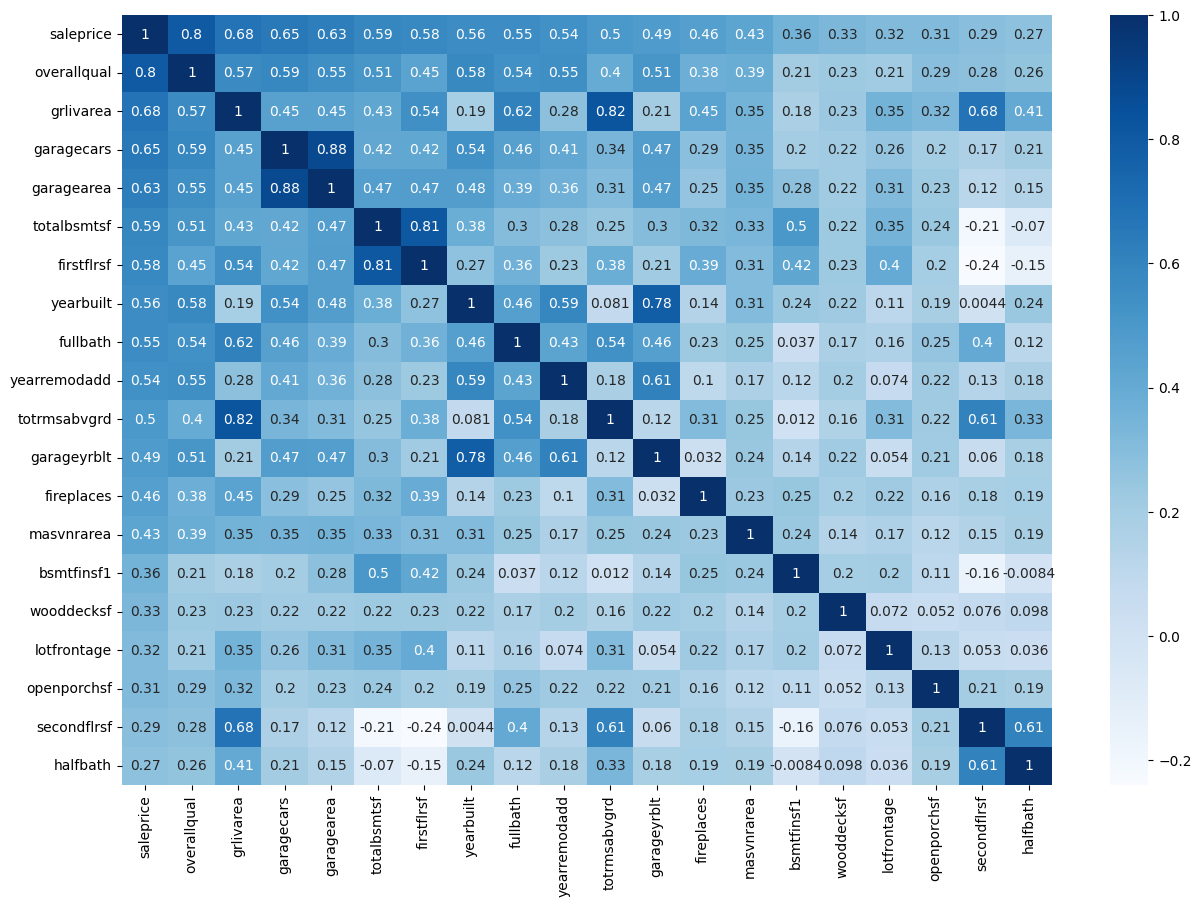

In [15]:
overall_correlation = house_price_df.corr()
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index
corr_of_correlated_columns = house_price_df[correlated_columns].corr()

fig=plt.figure(figsize=(15,10))
sns.heatmap(corr_of_correlated_columns,cmap='Blues',annot=True)

We previously found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [16]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

 We also found that we can improve the model by increasing the goodness of fit. To do this, we execute the steps below:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.

In [17]:
house_price_reduced_df = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names_reduced = [e for e in dummy_column_names if e not in unwanted_features]

We now finish creating the new dataframe with the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`. We also include the steps performed to increase the goodness of fit.

In [18]:
house_price_reduced_df['totalsf'] = house_price_reduced_df['totalbsmtsf'] + house_price_reduced_df['firstflrsf'] + house_price_reduced_df['secondflrsf']
house_price_reduced_df['int_over_sf'] = house_price_reduced_df['totalsf'] * house_price_reduced_df['overallqual']

house_price_reduced_df['saleprice'] = np.log1p(house_price_df['saleprice'])
house_price_reduced_df = house_price_reduced_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names_reduced]

We visualize these changes through a new heatmap.

<Axes: >

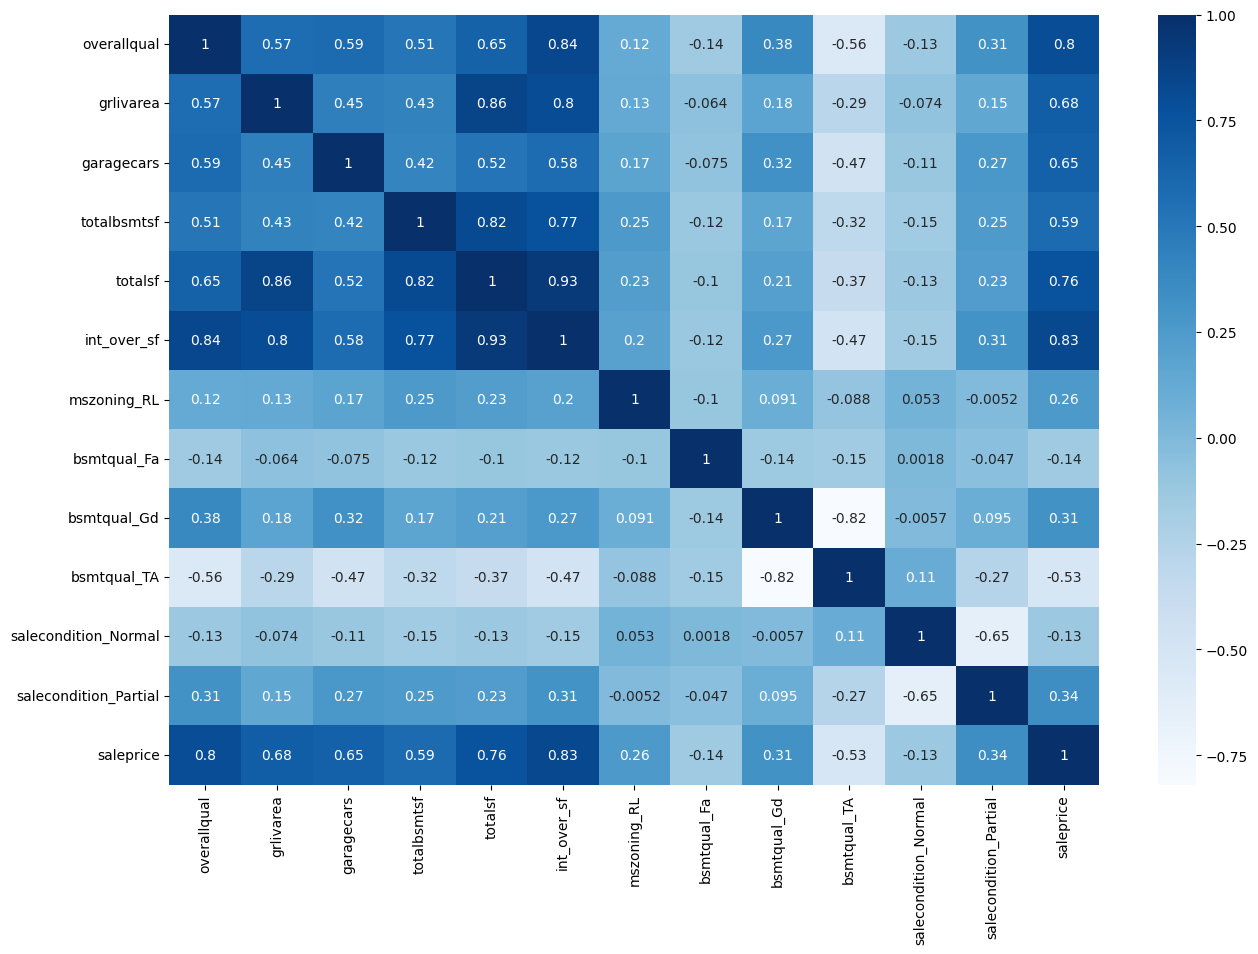

In [19]:
fig=plt.figure(figsize=(15,10))
house_price_corr_df = house_price_reduced_df.copy()
house_price_corr_df['saleprice'] = house_price_df['saleprice']
sns.heatmap(house_price_corr_df.corr(),cmap='Blues',annot=True)

In [20]:
house_price_reduced_df['saleprice'] = np.log1p(house_price_df['saleprice'])

### 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [22]:
# Y is the target variable
Y = np.log1p(house_price_df['saleprice'])
# X is the feature set
X = house_price_reduced_df

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


### 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.